In [1]:
import wandb

In [2]:
import os
os.environ.get("LD_LIBRARY_PATH")

'/eos/home-g/gkrzmanc/miniforge3/lib:/home/gkrzmanc/env/lib:'

In [36]:
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import torch
print("CUDA available:", torch.cuda.is_available())  # in case needed


def get_dataset():
    path = "/afs/cern.ch/work/g/gkrzmanc/mlpf_results/cluster_features_GT_clusters/cluster_features"
    r = {}
    n = 0
    #nmax = 257
    for file in os.listdir(path):
        #n += 1
        #if n > nmax:
        #    break
        f = pickle.load(open(os.path.join(path, file), "rb"))
        for key in f:
            if key not in r:
                r[key] = f[key]
            else:
                r[key] = torch.concatenate((r[key], f[key]), axis=0)
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    print("x shape:", r["x"].shape)
    return r["x"], x_names, r["true_e_corr"], r["e_true"], r["e_reco"]

def get_split(ds):
    from sklearn.model_selection import train_test_split
    x, _, y, etrue, _ = ds
    xtrain, xtest, ytrain, ytest, energiestrain, energiestest = train_test_split(
        x, y, etrue, test_size=0.2, random_state=42
    )
    return xtrain, xtest, ytrain, ytest, energiestrain, energiestest

def get_gb():
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(verbose=1)
    return model


def main(ds, train_only_on_tracks=False):
    split = list(get_split(ds))
    gpus = [0]
    wandb.init(project="mlpf_debug_energy_corr", entity="fcc_ml")
    #wandb.run.name = "Debug E correction"
    model = "gradboost"
    #wandb.run.model = model
    if model == "gradboost":
        model = get_gb()
        if train_only_on_tracks:
            mask = (split[0][:, 3] > 0) & (split[0][:, 7] > 0)
            split[0] = split[0][mask]
            split[2] = split[2][mask]
            split[4] = split[4][mask]
        result = model.fit(split[0], split[2])
        print("Fitted model:", result)
        # validation
        ypred = model.predict(split[1])
        ytrue = split[3]
        energies = split[5]
        return ytrue, ypred, energies, split[1], model, split
        # log scatterplots of validation results per energy
    else:
        raise NotImplementedError

def main_pandora():
    # just take the track p and energy of the hits for regression - so, "quasi-pandora"
    ds = get_dataset()
    print("Loaded dataset")
    split = get_split(ds)
    gpus = [0]
    wandb.init(project="mlpf_debug_energy_corr", entity="fcc_ml")
    #wandb.run.name = "Debug E correction"
    model = "gradboost"
    #wandb.run.model = model
    if model == "gradboost":
        model = get_gb()
        result = model.fit(split[0][:, [3, 6]], split[2])
        print("Fitted model:", result)
        # validation
        ypred = model.predict(split[1][:, [3, 6]])
        ytrue = split[3]
        energies = split[5]
        return ytrue, ypred, energies, split[1][:, [3, 6]], model, split
        # log scatterplots of validation results per energy
    else:
        raise NotImplementedError



CUDA available: True


In [37]:
ds = get_dataset()
print("Loaded dataset")

x shape: torch.Size([121070, 8])
Loaded dataset


In [34]:
yt_pandora, yp_pandora, en_pandora, _, model_pandora, split_pandora = main_pandora()

KeyboardInterrupt: 

In [39]:
yt, yp, en, _, model, split = main(ds=ds, train_only_on_tracks=True)


      Iter       Train Loss   Remaining Time 
         1           8.3034           11.14s
         2           6.8660           10.45s
         3           5.6901           10.14s
         4           4.7310            9.91s
         5           3.9499            9.71s
         6           3.3139            9.56s
         7           2.7884            9.41s
         8           2.3613            9.28s
         9           2.0103            9.16s
        10           1.7210            9.04s
        20           0.5492            7.94s
        30           0.3157            6.90s
        40           0.2284            5.90s
        50           0.1831            4.91s
        60           0.1534            3.92s
        70           0.1285            2.93s
        80           0.1177            1.95s
        90           0.1078            0.97s
       100           0.1007            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


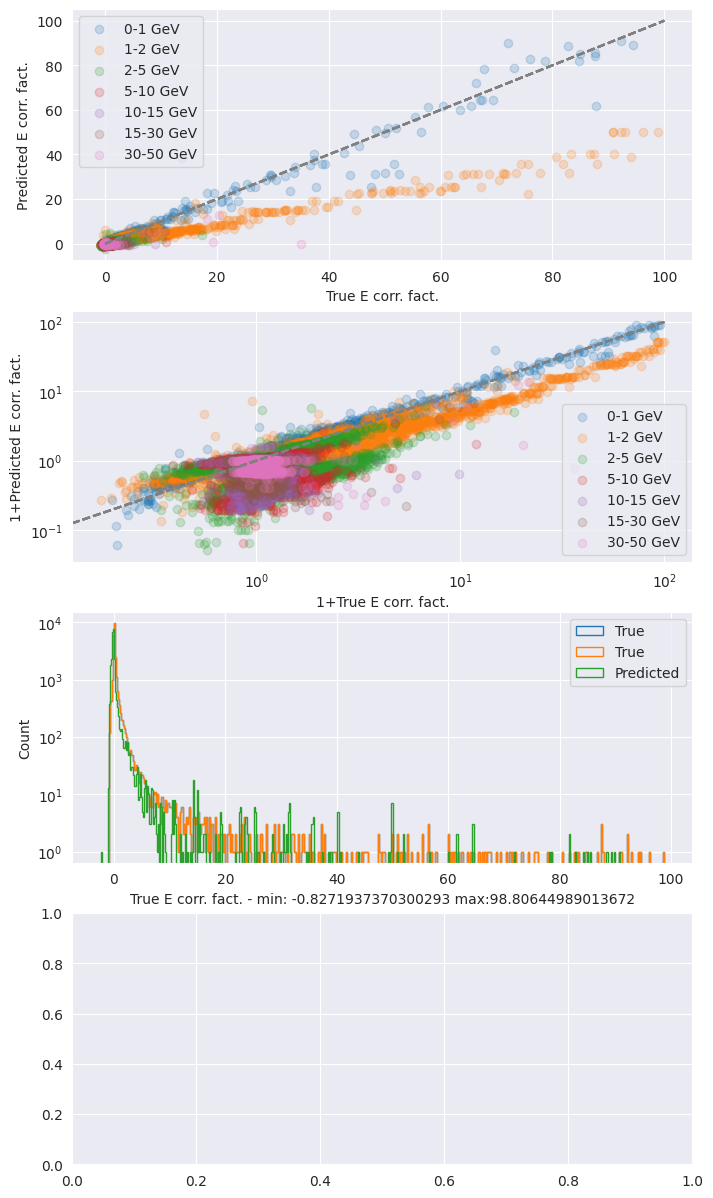

In [40]:
def plot(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(1+ytrue[mask], 1+ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("1+True E corr. fact.")
        ax[1].set_ylabel("1+Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        wandb.log({"validation": wandb.Image(fig)})

plot(yt, yp, en)

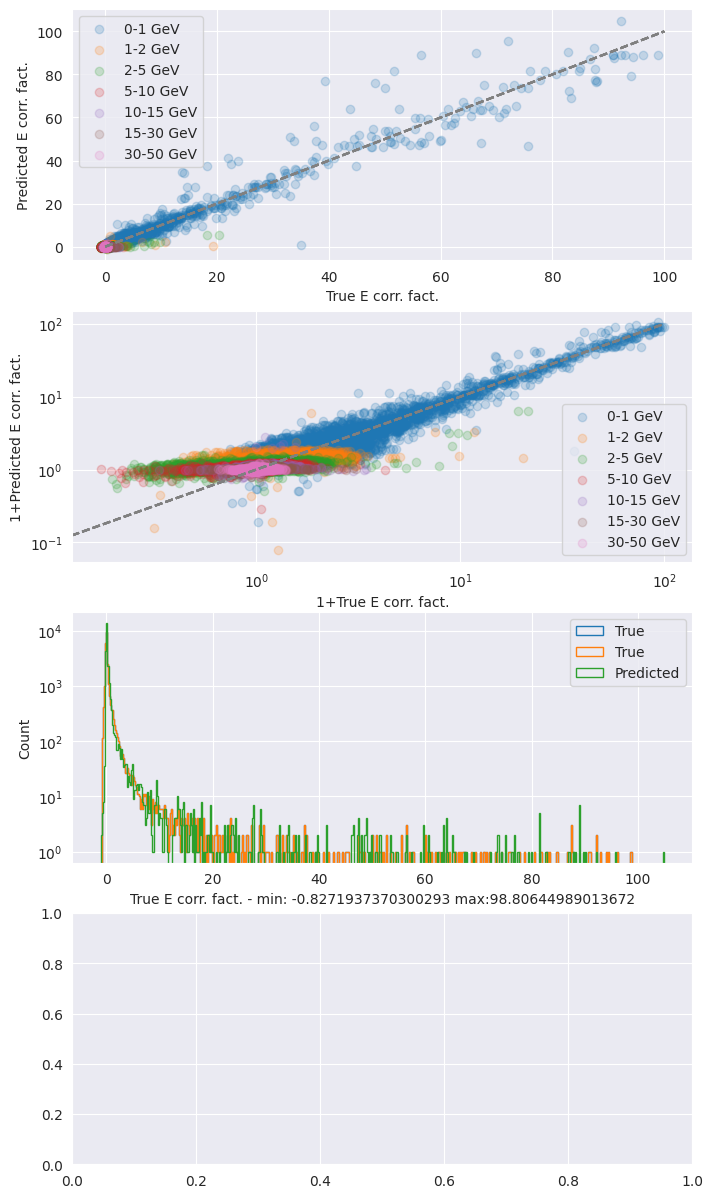

In [74]:
# ... Plotting with the energy of the sum of the hits...
plot(yt, yp, split[1][:, 6])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


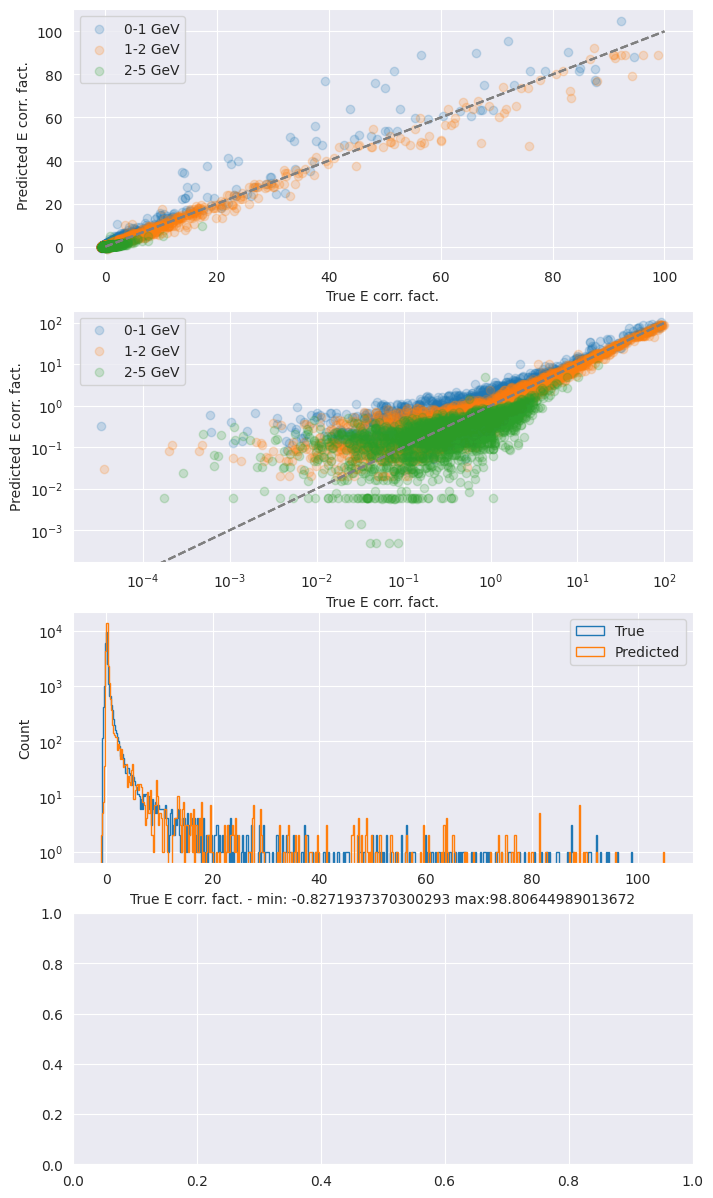

In [75]:
def plot1(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            if i not in [0, 1, 2]:
                continue
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("True E corr. fact.")
        ax[1].set_ylabel("Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        #ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        wandb.log({"validation": wandb.Image(fig)})
plot1(yt, yp, en)

In [70]:
import shap
te = shap.TreeExplainer(model)
shap_vals = te.shap_values(np.array(split[1]))

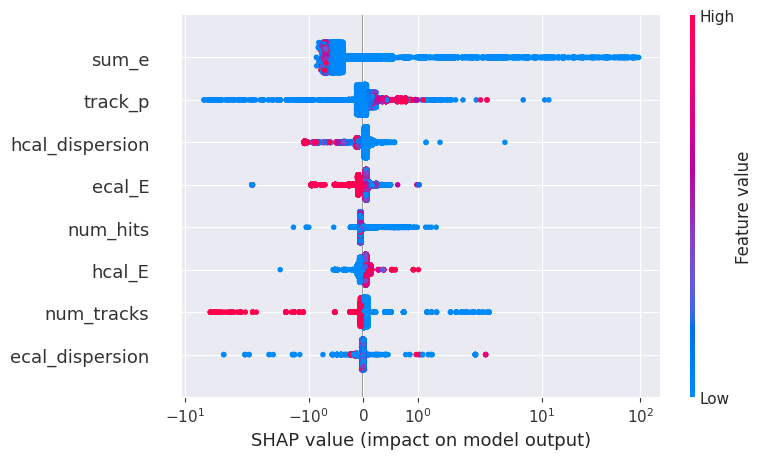

In [71]:
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
shap.summary_plot(shap_vals, split[1], feature_names=x_names, use_log_scale=True)

In [50]:
#for name in x_names:
#shap.dependence_plot(name, shap_vals, split[1], display_features=["sum_e"])


ValueError: Could not find feature named: ecal_E

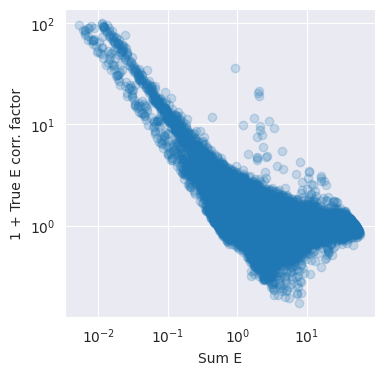

In [73]:
# just plot sum_e vs. true_e_corr.factor
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(split[1][:, 6], 1+yt, label="True", alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Sum E")
ax.set_ylabel("1 + True E corr. factor")
fig.show()

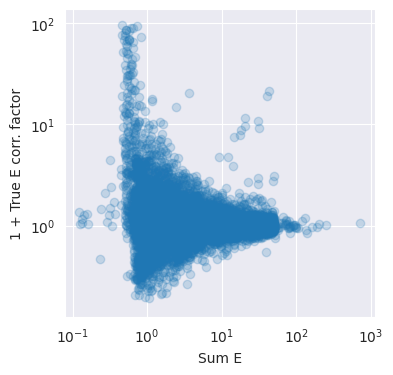

In [132]:
# just plot sum_e vs. true_e_corr.factor
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(split[1][:, 3], 1+yt, alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Sum E")
ax.set_ylabel("1 + True E corr. factor")
fig.show()

tensor(24214) 24214
Correlation coeff. all features: 0.980111675114 0.0
Correlation coeff. E+p: 0.9803803375538958 0.0


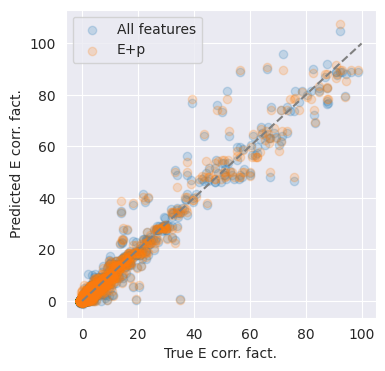

In [131]:
energies = split[1][:, 6]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
#mask = (energies > 0) & (energies < 1)
mask = (split[1][:, 3] > 0) & (split[1][:, 7] > 0)  # TRACKS
mask = energies > 0
print(mask.sum(), len(mask))
ax.scatter(yt[mask], yp[mask], label=f"All features", alpha=0.2)
ax.scatter(yt_pandora[mask], yp_pandora[mask], label=f"E+p", alpha=0.2)
# correlation coeff.
from scipy.stats import pearsonr
r, p = pearsonr(yt[mask], yp[mask])
r_pandora, p_pandora = pearsonr(yt_pandora[mask], yp_pandora[mask])
print("Correlation coeff. all features:", r, p)
print("Correlation coeff. E+p:", r_pandora, p_pandora)
ax.plot([0, 100], [0, 100], color="gray", linestyle="--")
ax.set_xlabel("True E corr. fact.")
ax.set_ylabel("Predicted E corr. fact.")
ax.legend()
fig.show()


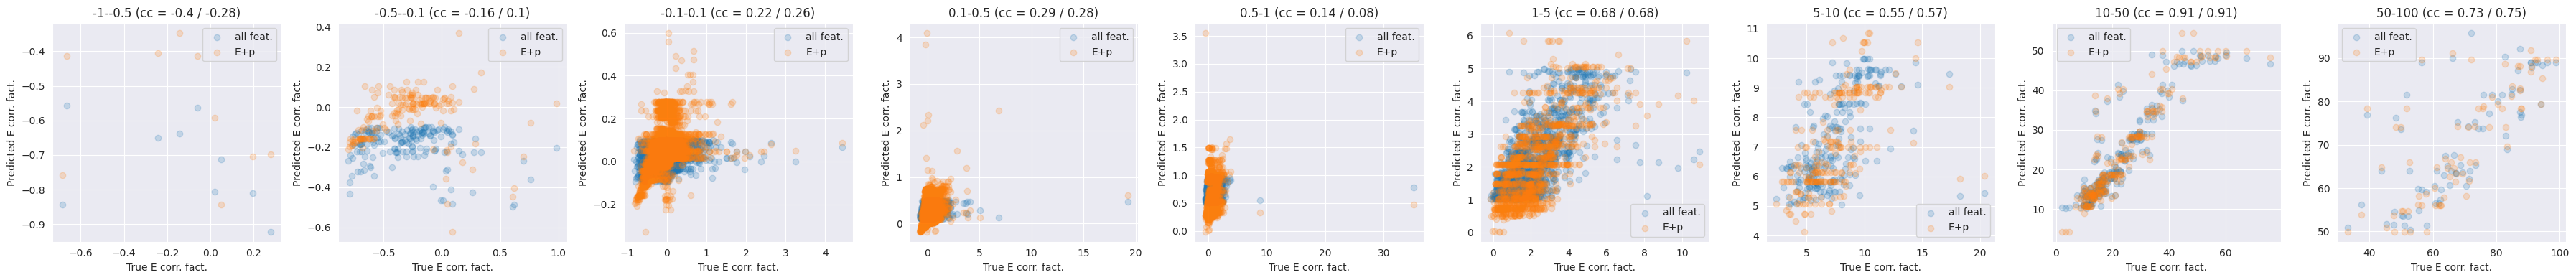

In [126]:
# define bins of the predicted corr. factor
bins = [-1, -0.75, -0.5, -0.25, -0.1, 0.1, 0.25, 0.5, 0.75, 1, 3, 5, 7, 10, 15, 30, 50, 100]
bins = [-1, -0.5, -0.1, 0.1, 0.5, 1, 5, 10, 50, 100]
n_plots = len(bins) - 1
corr_coeffs_ep, corr_coefs = [], []
bin_avg = []
fig, ax = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
track_filter = ((split[1][:, 3] > 0) & (split[1][:, 7] > 0).clone().detach().cpu().numpy())
import numpy as np
for i in range(len(bins) - 1):
    mask = (yp > bins[i]) & (yp < bins[i + 1]) & (track_filter).detach().cpu().numpy()
    bin_avg.append(yp[mask].mean())
    ax[i].scatter(yt[mask], yp[mask], alpha=0.2, label="all feat.")
    ax[i].scatter(yt_pandora[mask], yp_pandora[mask], alpha=0.2, label="E+p")
    cc = round(pearsonr(yt[mask], yp[mask])[0], 2)
    cc_ep = round(pearsonr(yt_pandora[mask], yp_pandora[mask])[0], 2)
    corr_coeffs_ep.append(cc_ep)
    corr_coefs.append(cc)
    ax[i].set_title(f"{bins[i]}-{bins[i+1]} (cc = {cc} / {cc_ep})")
    #ax[i].plot([0, 100], [0, 100], color="gray", linestyle="--")
    ax[i].set_xlabel("True E corr. fact.")
    ax[i].set_ylabel("Predicted E corr. fact.")
    ax[i].legend()
fig.tight_layout()
#fig.savefig("/eos/user/g/gkrzmanc/2024/xgb_correction/energy_corr_vs_true_corr_regions.pdf")
fig.show()


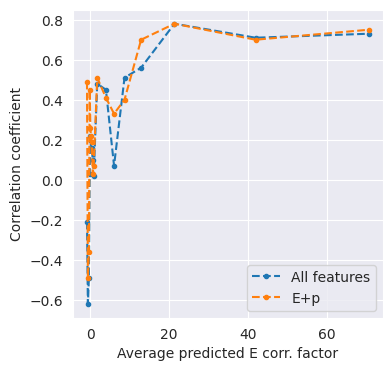

In [112]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(bin_avg, corr_coefs, ".--", label="All features")
ax.plot(bin_avg, corr_coeffs_ep, ".--", label="E+p")
ax.set_xlabel("Average predicted E corr. factor")
ax.set_ylabel("Correlation coefficient")
ax.legend()
fig.show()

In [42]:
import numpy as np
def get_std68(theHist, bin_edges, percentage=0.683, epsilon=0.01):
    # theHist, bin_edges = np.histogram(data_for_hist, bins=bins, density=True)
    wmin = 0.2
    wmax = 1.0

    weight = 0.0
    points = []
    sums = []

    # fill list of bin centers and the integral up to those point
    for i in range(len(bin_edges) - 1):
        weight += theHist[i] * (bin_edges[i + 1] - bin_edges[i])
        points.append([(bin_edges[i + 1] + bin_edges[i]) / 2, weight])
        sums.append(weight)
    low = wmin
    high = wmax
    width = 100
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
            if abs(wy - percentage) < epsilon:
                wx = points[j][0] - points[i][0]
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    width = wx
                    # ii = i
                    # jj = j

    return 0.5 * (high - low), low, high

def obtain_MPV_and_68(data_for_hist, bins_per_binned_E=np.arange(-1, 5, 0.01), epsilon=0.01):
    hist, bin_edges = np.histogram(data_for_hist, bins=bins_per_binned_E, density=True)
    ind_max_hist = np.argmax(hist)
    MPV = (bin_edges[ind_max_hist] + bin_edges[ind_max_hist + 1]) / 2
    std68, low, high = get_std68(hist, bin_edges, epsilon=epsilon)
    return MPV, std68

In [43]:

# mpv, s68 = obtain_MPV_and_68(energies, bins_per_binned_E=np.arange(0, 2.5*energies.max().item(), 0.05))

/tmp/gkrzmanc/ipykernel_39757/1271741067.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  ax.hist(frac_track[track_filter].clip(max=5), bins=100, color="green", label="with track - Pandora", alpha=0.5)
/tmp/gkrzmanc/ipykernel_39757/1271741067.py:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  ax.hist(frac_pred[track_filter], bins=100, color="red", label="with track", alpha=0.5)


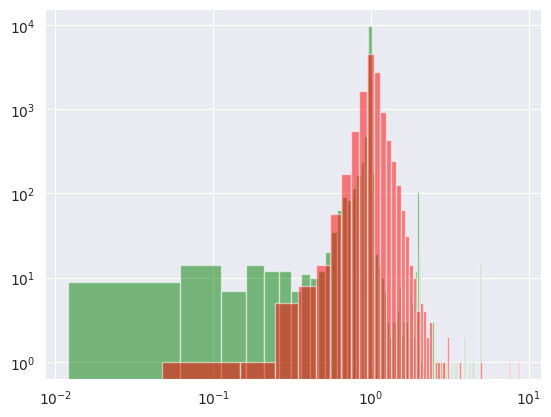

In [56]:
fig, ax = plt.subplots()
ax.hist(frac_track[track_filter].clip(max=5), bins=100, color="green", label="with track - Pandora", alpha=0.5)
ax.hist(frac_pred[track_filter], bins=100, color="red", label="with track", alpha=0.5)
ax.set_yscale("log")
ax.set_xscale("log")
fig.show()

sum tensor(2154)
1 0.775 0.20000000000000007 0.8830747834711419
sum tensor(4314)
2 1.1750000000000003 0.3500000000000001 1.5560148796719875
sum tensor(2317)
3 2.475 0.47499999999999987 2.6181118152760816
sum tensor(1554)
4 3.5250000000000004 0.5 3.656184919179176
sum tensor(1168)
5 4.375 0.625 4.661170401275967
sum tensor(3827)
10 6.075000000000001 1.7750000000000004 7.358498559740795
sum tensor(2190)
15 12.475000000000001 2.0 12.512683781249333
sum tensor(1540)
20 17.325000000000003 2.3249999999999993 17.582641271373717
sum tensor(1276)
25 23.225 2.3000000000000007 22.468066944106294
sum tensor(993)
30 28.425000000000004 2.5749999999999993 27.78048459941664
sum tensor(848)
35 33.975 2.799999999999997 32.25632466251279
sum tensor(734)
40 36.475 2.674999999999997 37.827440452700124
sum tensor(1299)
60 45.225 4.175000000000001 44.95881741660542


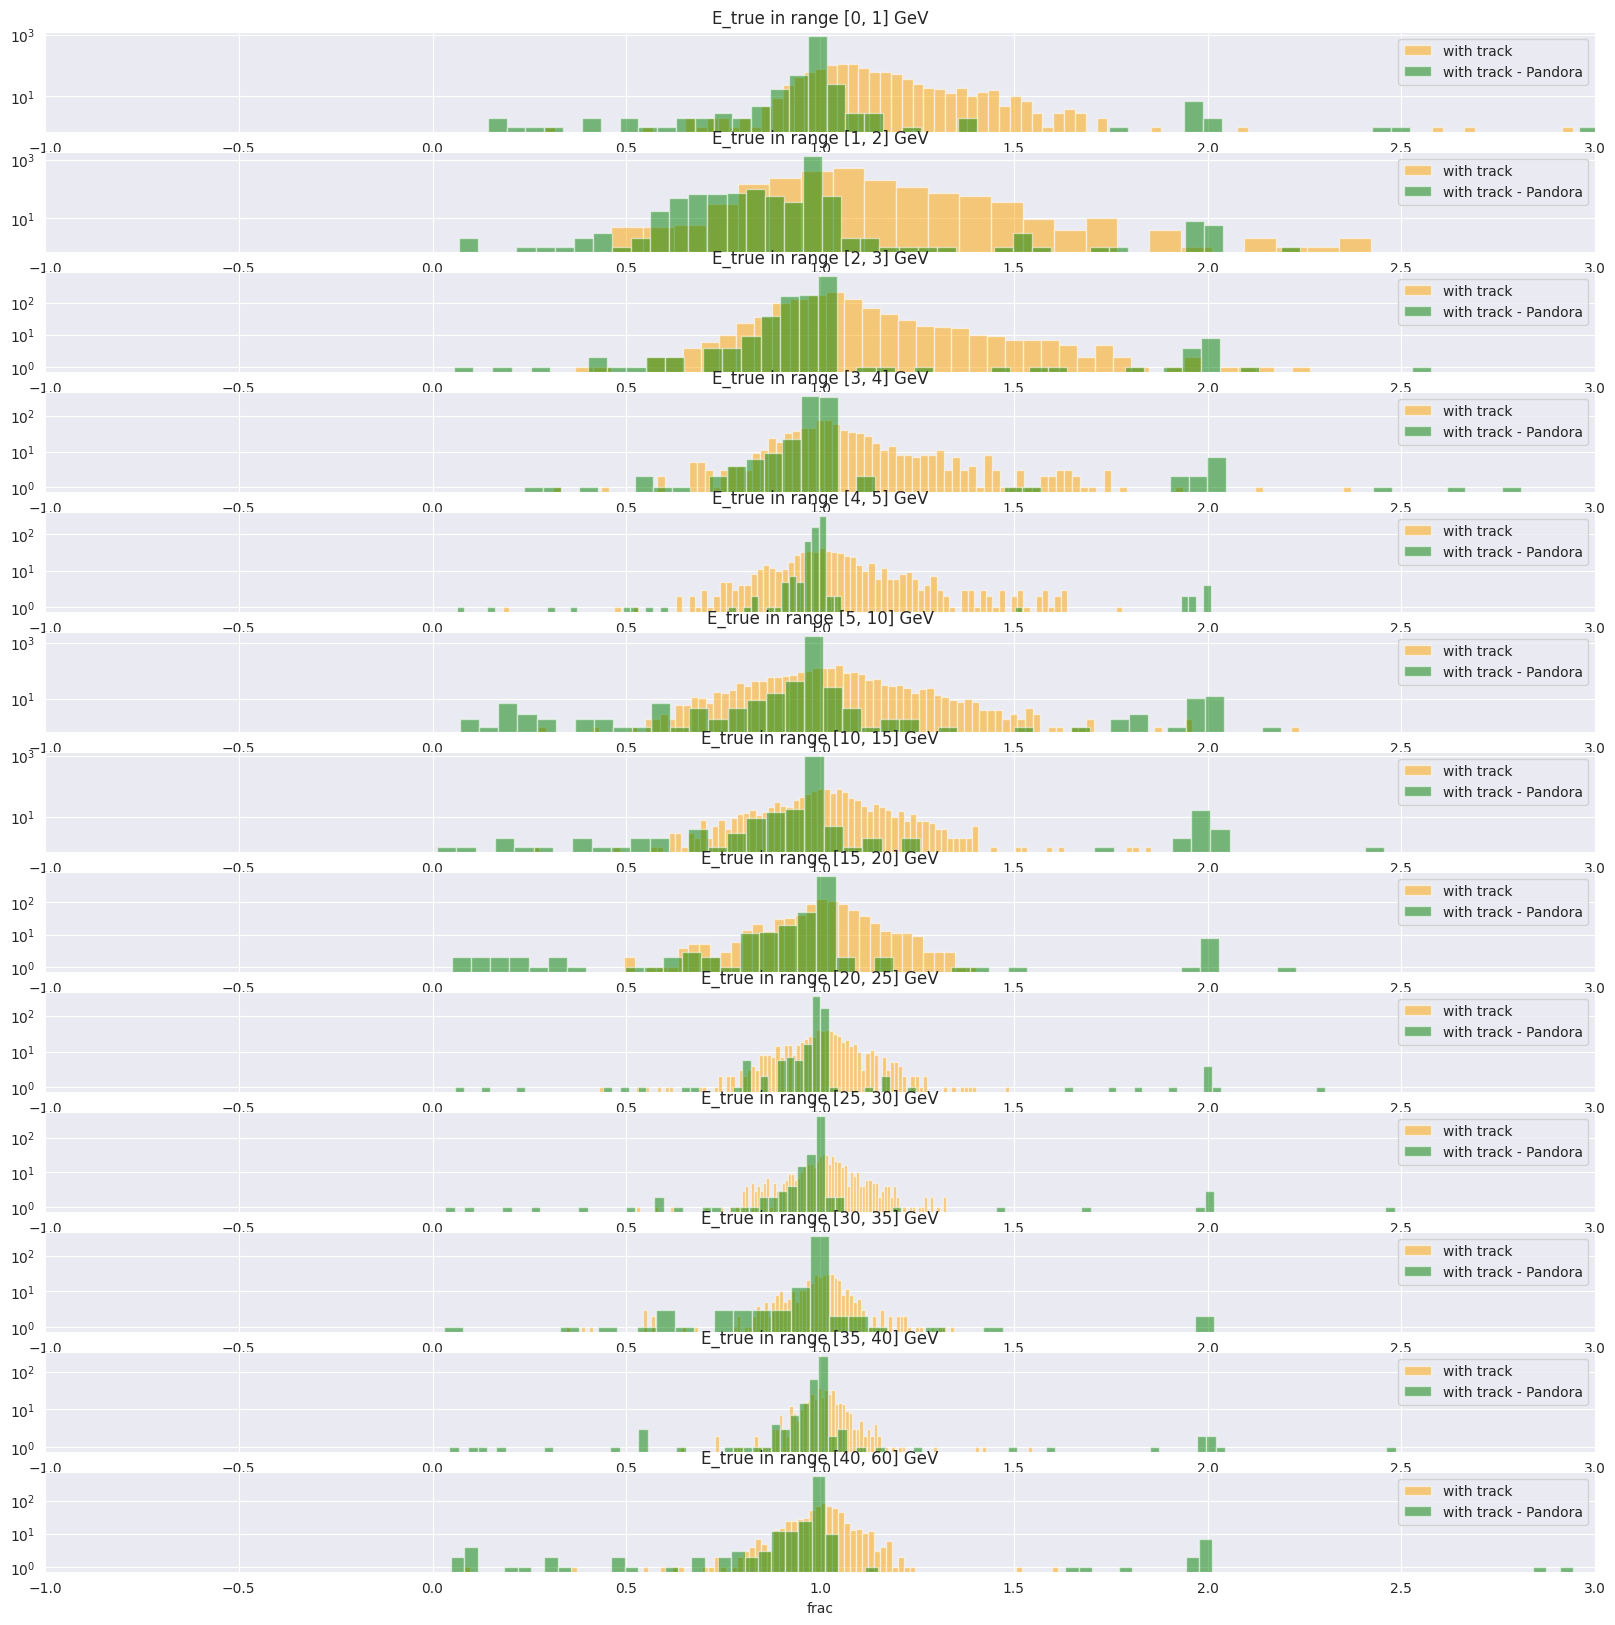

In [80]:
# Now do histograms for different energy bins: 1-2 GeV, 2-5 GeV, 5-10 GeV, 10+ GeV
# distribution of energy corr factor
e_thresholds = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 60]  # True E thresholds!
# set fig size
mpvs_model, s68s_model = [], []
mpvs_pandora, s68s_pandora = [], []

e_true = (1+yt) * split[1][:, 6].numpy()
e_pred = (1+yp) * split[1][:, 6].numpy()
frac_pred = e_pred / e_true
e_track = split[1][:, 3].clone().detach().cpu().numpy()
frac_track = e_track / e_true
track_filter = ((split[1][:, 3] > 0) & (split[1][:, 7] > 0))
not_track_filter = ~track_filter
fig, ax = plt.subplots(len(e_thresholds) - 1, figsize=(20, 20))
for i, e_threshold in enumerate(e_thresholds):
    if i == 0:
        continue
    filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
    print("sum", filt_energy.sum())
    ax[i-1].hist(frac_pred[track_filter & filt_energy], bins=100, color="orange", label="with track", alpha=0.5)
    ax[i-1].hist(frac_track.clip(max=5)[track_filter & filt_energy], bins=100, color="green", label="with track - Pandora", alpha=0.5)
    mpv, s68 = obtain_MPV_and_68(e_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], 0.05))
    mpvs_model, s68s_model = mpvs_model + [mpv], s68s_model + [s68]
    mpv, s68 = obtain_MPV_and_68(e_track[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], 0.05))
    mpvs_pandora, s68s_pandora = mpvs_pandora + [mpv], s68s_pandora + [s68]
    # now with filt ecalE and hcalE
    #mpvs.append(1/2 * (e_thresholds[i] + e_thresholds[i-1]))
    #mpvs.append(mpv)
    #s68s.append(s68)
    #print(f"MPV: {mpv}, 68%: {s68}")
    # only hadronic
    ax[i-1].set_xlabel("frac")
    ax[i-1].set_xlim([-1,3])
    ax[i-1].set_title(f"E_true in range [{e_thresholds[i-1]}, {e_thresholds[i]}] GeV")
    # log x axis
    ax[i-1].set_yscale("log")
    ax[i-1].legend()
fig.show()

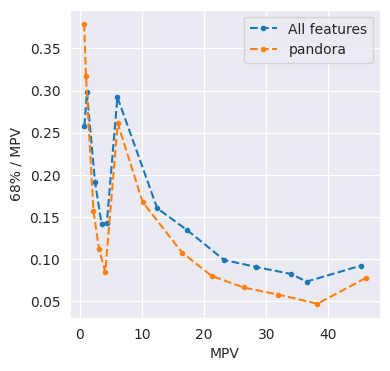

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(mpvs_model, np.array(s68s_model) / np.array(mpvs_model), ".--", label="All features")
ax.plot(mpvs_pandora, np.array(s68s_pandora) / np.array(mpvs_pandora), ".--", label="pandora")
ax.legend()
ax.set_xlabel("MPV")
ax.set_ylabel("68% / MPV")
fig.show()


In [20]:
frac_pred[track_filter].max()

/tmp/gkrzmanc/ipykernel_39757/2164183012.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  frac_pred[track_filter].max()


tensor(4.9051, dtype=torch.float64)

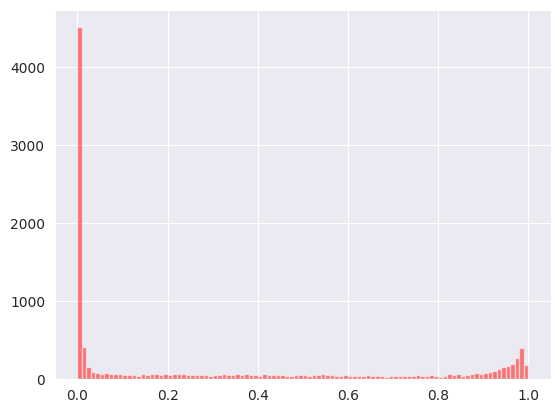

In [81]:
fig, ax = plt.subplots()
ax.hist(split[1][:, 1].numpy()[track_filter], bins=100, color="red", label="with track", alpha=0.5)
fig.show()

In [72]:
track_filter.sum()

tensor(11636)